# **AF7_MySdeSM**
**Proyecto final**

**Ecuación caracteristica de un sistema mecanico de un robot manipulador planar de 2 grados de libertad a partir del formalismo Euler-Lagrange.**

Librerías

In [4]:
import numpy as np
import matplotlib.pyplot as plt

Parametros y funciones

In [5]:
def M_matrix(q):
    q2 = q[1]
    M11 = 3.117 + 0.2 * np.cos(q2)
    M12 = 0.108 + 0.1 * np.cos(q2)
    M21 = M12
    M22 = 0.108
    return np.array([[M11, M12],
                     [M21, M22]])

def C_matrix(q, qp):
    q2 = q[1]
    q1p = qp[0]; q2p = qp[1]
    c11 = -0.2 * np.sin(q2) * q2p
    c12 = -0.1 * np.sin(q2) * q2p
    c21 =  0.1 * np.sin(q2) * q1p
    c22 =  0.0
    return np.array([[c11, c12],
                     [c21, c22]])

def grav_vec(q):
    q1 = q[0]; q2 = q[1]
    return np.array([39.3*np.sin(q1) + 1.95*np.sin(q1+q2),
                     1.95*np.sin(q1+q2)])

def friction_vec(qp, smooth=True):
    """Fricción: viscosa + Coulomb. Si smooth=True usa tanh para aproximar sign."""
    q1p, q2p = qp
    if smooth:
        s1 = np.tanh(1000.0 * q1p)
        s2 = np.tanh(1000.0 * q2p)
    else:
        s1 = np.sign(q1p); s2 = np.sign(q2p)
    f1 = 1.86 * q1p + 1.93 * s1
    f2 = 0.16 * q2p + 0.3  * s2
    return np.array([f1, f2])

def tau_profile(t):
    tau1 = (1.0 - np.exp(-0.8*t)) * 32.0 + 56.0*np.sin(16.0*t + 0.1) + 12.0*np.sin(20.0*t + 0.15)
    tau2 = (1.0 - np.exp(-1.8*t)) * 1.2  +  8.0*np.sin(26.0*t + 0.08) +  2.0*np.sin(12.0*t + 0.34)
    return np.array([tau1, tau2])

Dinaamica

In [6]:
def accel(q, qp, t, smooth_fric=True):
    M = M_matrix(q)
    C = C_matrix(q, qp)
    g = grav_vec(q)
    fr = friction_vec(qp, smooth=smooth_fric)
    tau = tau_profile(t)
    RHS = tau - (C @ qp) - g - fr
    qdd = np.linalg.solve(M, RHS)
    return qdd

Integrador

In [7]:
def rk4_step(x, t, h, smooth_fric=True):
    # x = [q1, q2, q1p, q2p]
    def fstate(x_local, t_local):
        q = x_local[0:2]; qp = x_local[2:4]
        qdd = accel(q, qp, t_local, smooth_fric=smooth_fric)
        dx = np.zeros(4)
        dx[0:2] = qp
        dx[2:4] = qdd
        return dx
    k1 = fstate(x, t)
    k2 = fstate(x + 0.5*h*k1, t + 0.5*h)
    k3 = fstate(x + 0.5*h*k2, t + 0.5*h)
    k4 = fstate(x + h*k3, t + h)
    return x + (h/6.0) * (k1 + 2*k2 + 2*k3 + k4)

Simulación

In [8]:
ti = 0.0
tf = 10.0
h  = 0.0025
ts = np.arange(ti, tf + h, h)

# condiciones iniciales (reposo)
x = np.zeros((4, len(ts)))   # filas: estados, columnas: tiempo
x[:, 0] = np.array([0.0, 0.0, 0.0, 0.0])

# Bucle de integración
for k in range(len(ts)-1):
    t_k = ts[k]
    x[:, k+1] = rk4_step(x[:, k], t_k, h, smooth_fric=True)

# Extraer resultados
q1 = x[0, :]
q2 = x[1, :]
q1_deg = np.rad2deg(q1)
q2_deg = np.rad2deg(q2)

Graficas con respecto al tiempo


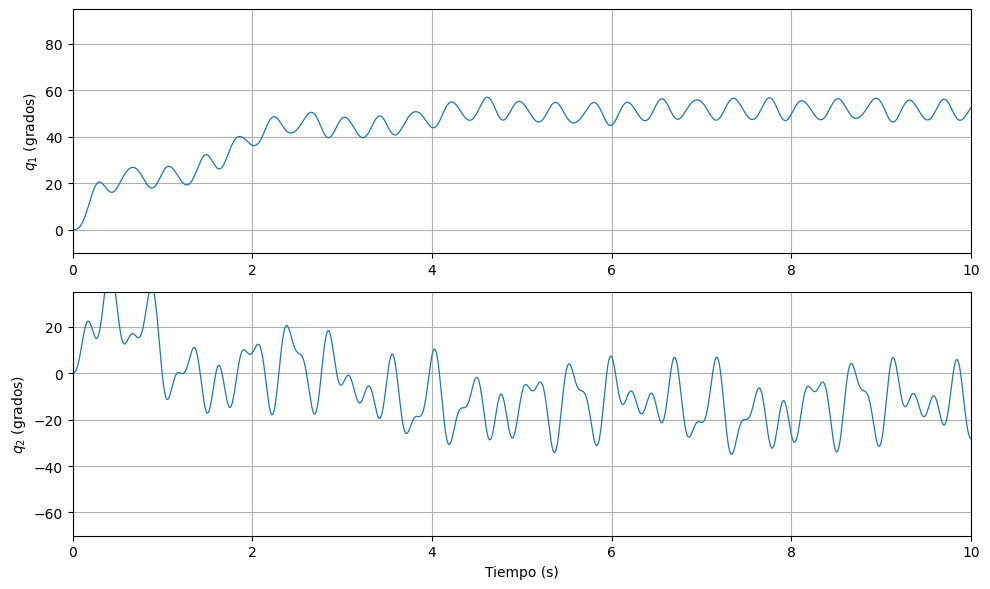

In [9]:
plt.figure(figsize=(10,6))

ax1 = plt.subplot(2,1,1)
ax1.plot(ts, q1_deg, linewidth=0.9)
ax1.set_ylabel(r'$q_1$ (grados)')
ax1.set_xlim(ti, tf)
ax1.set_ylim(-10, 95)
ax1.grid(True)

ax2 = plt.subplot(2,1,2, sharex=ax1)
ax2.plot(ts, q2_deg, linewidth=0.9)
ax2.set_ylabel(r'$q_2$ (grados)')
ax2.set_xlabel('Tiempo (s)')
ax2.set_xlim(ti, tf)
ax2.set_ylim(-70, 35)
ax2.grid(True)

plt.tight_layout()
plt.show()
